# Optimization WFA - Linear Regression

## Linear Regression with scikit-learn 

In [1]:
import sys
sys.path.append('../../')

In [2]:
from util.load_data import *
from config.constants import *
from util.plot_equity import plot_equity_trades
from util.Save_result_return import save_to_csv

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
plt.style.use("seaborn-v0_8")

In [4]:
from backtesting import Strategy

In [5]:
import warnings
warnings.simplefilter("ignore")

## Getting the Data

In [6]:
XAUUSD = load_data()

In [13]:
XAUUSD['H4'].Close

Time
2007-01-01 00:00:00     635.497
2007-01-01 04:00:00     635.699
2007-01-01 08:00:00     635.993
2007-01-01 12:00:00     636.006
2007-01-01 16:00:00     635.989
                         ...   
2023-03-10 00:00:00    1829.085
2023-03-10 04:00:00    1833.405
2023-03-10 08:00:00    1834.865
2023-03-10 12:00:00    1862.975
2023-03-10 16:00:00    1864.098
Name: Close, Length: 25976, dtype: float64

In [14]:
XAUUSD['H4'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25976 entries, 2007-01-01 00:00:00 to 2023-03-10 16:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    25976 non-null  float64
 1   High    25976 non-null  float64
 2   Low     25976 non-null  float64
 3   Close   25976 non-null  float64
 4   Volume  25976 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 1.2 MB


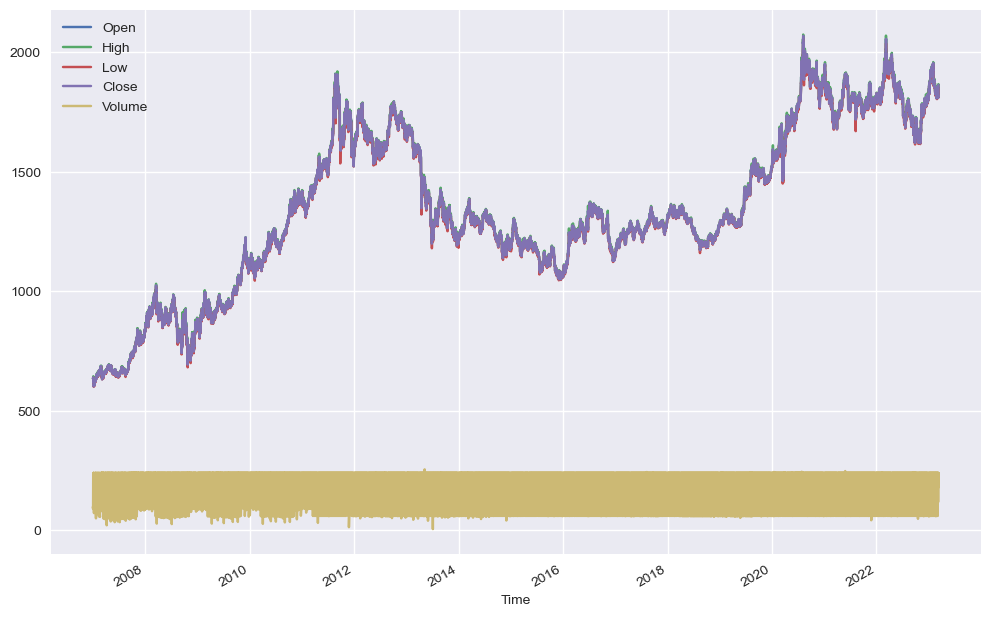

In [15]:
XAUUSD['H4'].plot(figsize = (12, 8))
plt.show()

## ML

### Class and Strategy ML

In [7]:
class Linear_Regression(Strategy):

    def init(self):
        pass

    def next(self):

        if self.data.pred[-1] == 1:
            if not self.position :
                self.buy(size=1)
            elif self.position.is_short:
                self.position.close()
                self.buy(size=1)
            
        elif self.data.pred[-1] == -1:
            if not self.position:
                self.sell(size=1)
            elif self.position.is_long:
                self.position.close()
                self.sell(size=1)

        

In [8]:
mainFolder = 'Machine_Learning'
strategy = Linear_Regression
strategyName = 'Linear_Regression'
account_size = 1000
folder_ML_Strategy = 'Linear Regression'
subFolder = 'Optimization'

In [9]:
from backtesting import Backtest
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd
from util.Save_result_return import save_to_csv

plt.style.use("seaborn-v0_8")

In [10]:
class ML_Regression():

    def __init__(self, data, strategy, start_train,  end_train,  TF, window_size , account_size):
        self.data = data
        self.strategy = strategy
        self.start_train = start_train
        self.end_train = end_train
        self.TF = TF
        self.window_size = window_size
        self.account_size = account_size
        self.data_train = None
        self.results = None
        self.model = None

    def Prepare(self, lags=0):
        data = self.data.loc[self.start_train:self.end_train].copy()
        data["returns"] = np.log(data['Close'] / data['Close'].shift(1))
        data['returns_signal'] = data['returns'].shift(-1)
        data.dropna(inplace=True)
        cols = []
        for lag in range(lags + 1):
            col = "lag{}".format(lag)
            data[col] = data['returns'].shift(lag)
            cols.append(col)
        data.dropna(inplace=True)
        data['pred'] = 0

        for i in range(self.window_size, len(data)):
            rolling_window_data = data.iloc[i - self.window_size :i ]

            lm = LinearRegression(fit_intercept=True)
            lm.fit(rolling_window_data[cols], rolling_window_data['returns_signal'])

            # Predict for the next data point
            pred_value = lm.predict(
                np.array(data[cols].iloc[i] ).reshape(1, -1))
            data.at[data.index[i], 'pred'] = np.sign(pred_value[0])

        self.model = lm
        self.data_train = data.copy()


    def Backtest(self, data):
        # Assuming you have a Backtest class that performs backtesting
        account_size = self.account_size
        backtest = Backtest(data, self.strategy, cash = account_size  , margin= 1/100)
        result = backtest.run()
        return result

    

    def Run(self) :
        self.Prepare()
        result_train = self.Backtest(self.data_train)

        return result_train

## TF D1

In [183]:
start_train = '2007'
end_train = '2023'
account_size = 1000
TF = 'D1'

### Window size 1 year

In [184]:
data = XAUUSD['D1']
window_size = 252
WFA = '1y'

In [185]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [186]:
test = ml.Run()

In [187]:
test

Start                     2007-01-02 00:00:00
End                       2023-03-09 00:00:00
Duration                   5910 days 00:00:00
Exposure Time [%]                   94.981155
Equity Final [$]                     1035.278
Equity Peak [$]                      1767.613
Return [%]                             3.5278
Buy & Hold Return [%]              186.542292
Return (Ann.) [%]                    0.173466
Volatility (Ann.) [%]               18.317358
Sharpe Ratio                          0.00947
Sortino Ratio                        0.013453
Calmar Ratio                          0.00275
Max. Drawdown [%]                  -63.082643
Avg. Drawdown [%]                   -5.110224
Max. Drawdown Duration     4217 days 00:00:00
Avg. Drawdown Duration      169 days 00:00:00
# Trades                                 1251
Win Rate [%]                        49.880096
Best Trade [%]                      14.391892
Worst Trade [%]                    -12.501752
Avg. Trade [%]                    

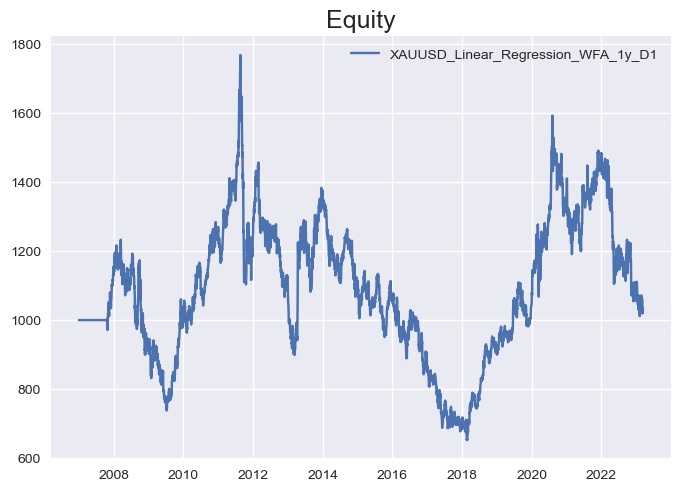

In [188]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [189]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [190]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 2 year

In [191]:
data = XAUUSD['D1']
window_size = 252 * 2
WFA = '2y'

In [192]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [193]:
test = ml.Run()

In [194]:
test

Start                     2007-01-02 00:00:00
End                       2023-03-09 00:00:00
Duration                   5910 days 00:00:00
Exposure Time [%]                   89.982146
Equity Final [$]                     1366.298
Equity Peak [$]                      2273.667
Return [%]                            36.6298
Buy & Hold Return [%]              186.542292
Return (Ann.) [%]                     1.57245
Volatility (Ann.) [%]               13.209815
Sharpe Ratio                         0.119036
Sortino Ratio                        0.170908
Calmar Ratio                         0.039402
Max. Drawdown [%]                  -39.907735
Avg. Drawdown [%]                   -3.766973
Max. Drawdown Duration     3228 days 00:00:00
Avg. Drawdown Duration      112 days 00:00:00
# Trades                                  871
Win Rate [%]                        50.057405
Best Trade [%]                       50.35184
Worst Trade [%]                    -18.748241
Avg. Trade [%]                    

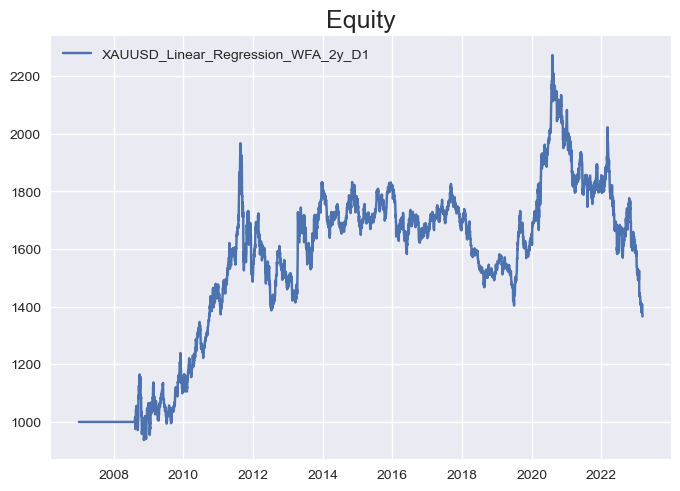

In [195]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [196]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [197]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 3 year

In [198]:
data = XAUUSD['D1']
window_size = 252 * 3
WFA = '3y'

In [199]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [200]:
test = ml.Run()

In [201]:
test

Start                     2007-01-02 00:00:00
End                       2023-03-09 00:00:00
Duration                   5910 days 00:00:00
Exposure Time [%]                   84.983138
Equity Final [$]                      342.028
Equity Peak [$]                      1644.225
Return [%]                           -65.7972
Buy & Hold Return [%]              186.542292
Return (Ann.) [%]                   -5.221964
Volatility (Ann.) [%]               33.319346
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -89.407897
Avg. Drawdown [%]                   -7.283413
Max. Drawdown Duration     4217 days 00:00:00
Avg. Drawdown Duration      227 days 00:00:00
# Trades                                  630
Win Rate [%]                        51.428571
Best Trade [%]                      18.029684
Worst Trade [%]                    -13.664747
Avg. Trade [%]                    

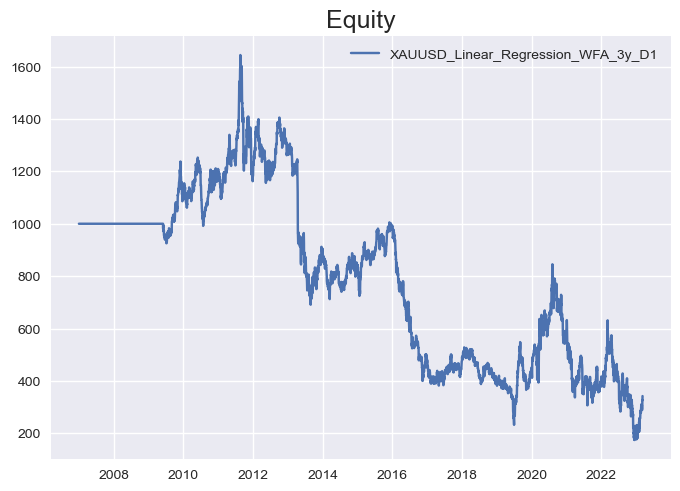

In [202]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [203]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [204]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 4 year

In [205]:
data = XAUUSD['D1']
window_size = 252 * 4
WFA = '4y'

In [206]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [207]:
test = ml.Run()

In [208]:
test

Start                     2007-01-02 00:00:00
End                       2023-03-09 00:00:00
Duration                   5910 days 00:00:00
Exposure Time [%]                    79.98413
Equity Final [$]                       937.74
Equity Peak [$]                      1901.918
Return [%]                             -6.226
Buy & Hold Return [%]              186.542292
Return (Ann.) [%]                   -0.320833
Volatility (Ann.) [%]               18.405809
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -72.207845
Avg. Drawdown [%]                   -3.422045
Max. Drawdown Duration     4213 days 00:00:00
Avg. Drawdown Duration      112 days 00:00:00
# Trades                                  647
Win Rate [%]                        49.459042
Best Trade [%]                      17.266448
Worst Trade [%]                    -11.089311
Avg. Trade [%]                    

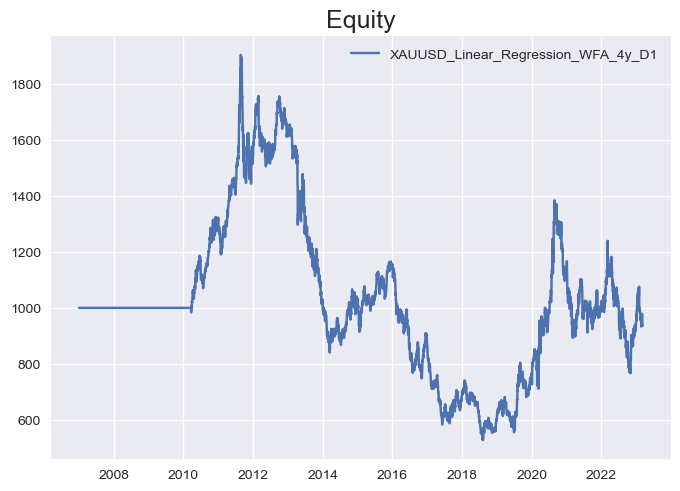

In [209]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [210]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [211]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 5 year

In [212]:
data = XAUUSD['D1']
window_size = 252 * 5
WFA = '5y'

In [213]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [214]:
test = ml.Run()

In [215]:
test

Start                     2007-01-02 00:00:00
End                       2023-03-09 00:00:00
Duration                   5910 days 00:00:00
Exposure Time [%]                   74.985122
Equity Final [$]                     1423.149
Equity Peak [$]                      1727.536
Return [%]                            42.3149
Buy & Hold Return [%]              186.542292
Return (Ann.) [%]                    1.779661
Volatility (Ann.) [%]               17.749684
Sharpe Ratio                         0.100264
Sortino Ratio                        0.142223
Calmar Ratio                         0.027792
Max. Drawdown [%]                  -64.036084
Avg. Drawdown [%]                   -6.603016
Max. Drawdown Duration     3256 days 00:00:00
Avg. Drawdown Duration      210 days 00:00:00
# Trades                                  587
Win Rate [%]                          56.0477
Best Trade [%]                      23.042593
Worst Trade [%]                    -16.911018
Avg. Trade [%]                    

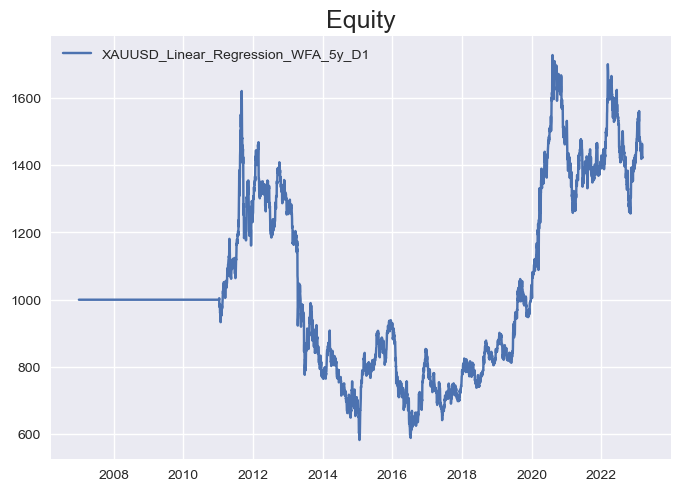

In [216]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [217]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [218]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 6 year

In [219]:
data = XAUUSD['D1']
window_size = 252 * 6
WFA = '6y'

In [220]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [221]:
test = ml.Run()

In [222]:
test

Start                     2007-01-02 00:00:00
End                       2023-03-09 00:00:00
Duration                   5910 days 00:00:00
Exposure Time [%]                   26.740726
Equity Final [$]                          0.0
Equity Peak [$]                       1079.69
Return [%]                             -100.0
Buy & Hold Return [%]              186.542292
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]               88.768247
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                      -100.0
Avg. Drawdown [%]                  -34.747235
Max. Drawdown Duration     4134 days 00:00:00
Avg. Drawdown Duration     1382 days 00:00:00
# Trades                                  148
Win Rate [%]                         45.27027
Best Trade [%]                       8.224963
Worst Trade [%]                    -12.786673
Avg. Trade [%]                    

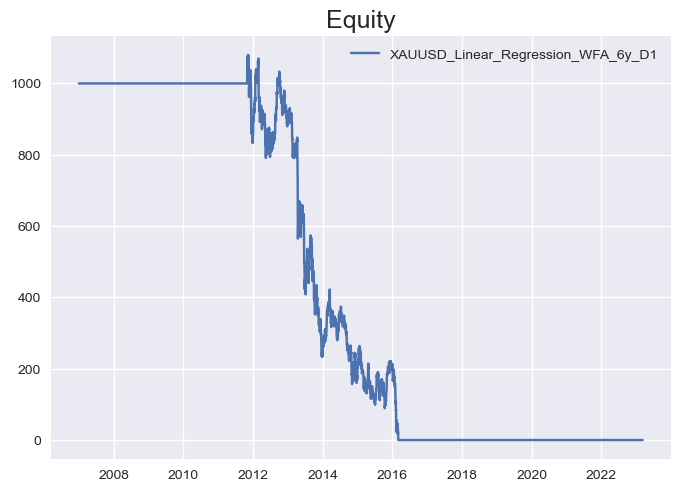

In [223]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [224]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [225]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 7 year

In [226]:
data = XAUUSD['D1']
window_size = 252 * 7
WFA = '7y'

In [227]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [228]:
test = ml.Run()

In [229]:
test

Start                     2007-01-02 00:00:00
End                       2023-03-09 00:00:00
Duration                   5910 days 00:00:00
Exposure Time [%]                   53.025193
Equity Final [$]                          0.0
Equity Peak [$]                      1120.498
Return [%]                             -100.0
Buy & Hold Return [%]              186.542292
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]              182.417665
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                      -100.0
Avg. Drawdown [%]                  -13.266405
Max. Drawdown Duration     3808 days 00:00:00
Avg. Drawdown Duration      480 days 00:00:00
# Trades                                  475
Win Rate [%]                             52.0
Best Trade [%]                       9.977931
Worst Trade [%]                    -11.396337
Avg. Trade [%]                    

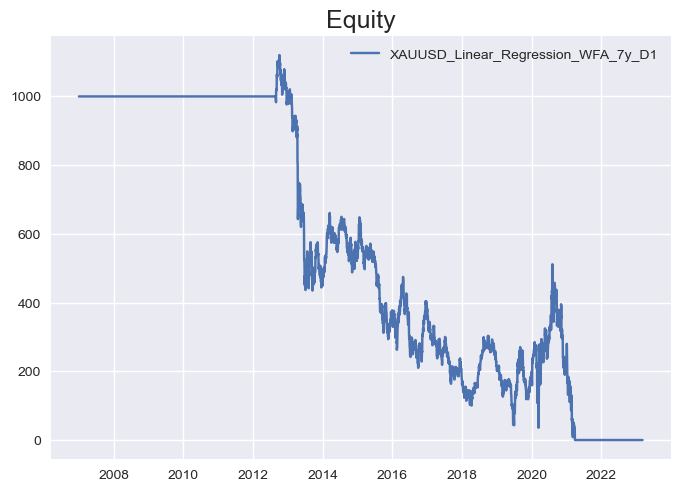

In [230]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [231]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [232]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 8 year

In [233]:
data = XAUUSD['D1']
window_size = 252 * 8
WFA = '8y'

In [234]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [235]:
test = ml.Run()

In [236]:
test

Start                     2007-01-02 00:00:00
End                       2023-03-09 00:00:00
Duration                   5910 days 00:00:00
Exposure Time [%]                   59.988098
Equity Final [$]                      586.006
Equity Peak [$]                      1028.471
Return [%]                           -41.3994
Buy & Hold Return [%]              186.542292
Return (Ann.) [%]                   -2.636225
Volatility (Ann.) [%]               32.321386
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -81.032426
Avg. Drawdown [%]                  -33.211253
Max. Drawdown Duration     3481 days 00:00:00
Avg. Drawdown Duration     1184 days 00:00:00
# Trades                                  497
Win Rate [%]                        51.911469
Best Trade [%]                      11.933634
Worst Trade [%]                    -11.022242
Avg. Trade [%]                    

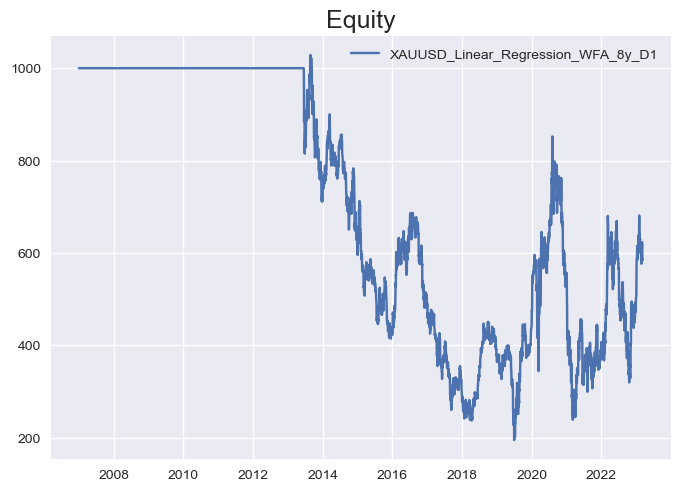

In [237]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [238]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [239]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

## TF H4

In [240]:
start_train = '2007'
end_train = '2023'
account_size = 1000
TF = 'H4'

### Window size 1 year

In [241]:
data = XAUUSD['H4']
window_size = 252 * 6
WFA = '1y'

In [242]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [243]:
test = ml.Run()

In [244]:
test

Start                     2007-01-01 04:00:00
End                       2023-03-10 12:00:00
Duration                   5912 days 08:00:00
Exposure Time [%]                   94.174944
Equity Final [$]                      350.392
Equity Peak [$]                      1367.783
Return [%]                           -64.9608
Buy & Hold Return [%]              193.059294
Return (Ann.) [%]                   -5.105453
Volatility (Ann.) [%]               28.846798
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -80.086754
Avg. Drawdown [%]                   -5.262597
Max. Drawdown Duration     4217 days 12:00:00
Avg. Drawdown Duration      158 days 23:00:00
# Trades                                 5962
Win Rate [%]                        49.094264
Best Trade [%]                      21.603568
Worst Trade [%]                    -14.856365
Avg. Trade [%]                    

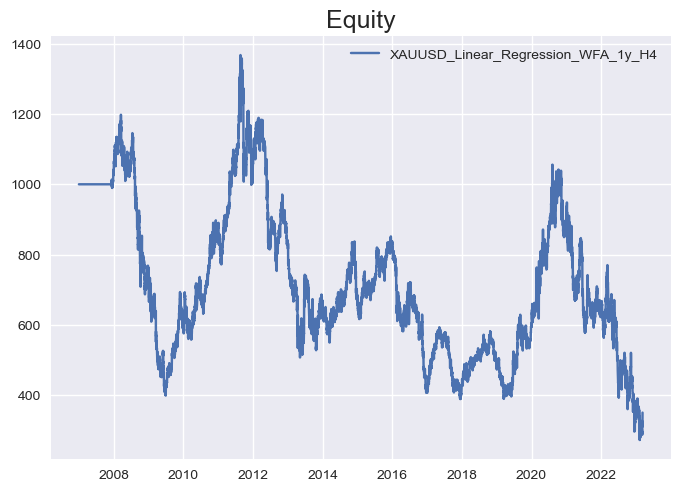

In [245]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [246]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [247]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 2 year

In [248]:
data = XAUUSD['H4']
window_size = 252 * 2 * 6
WFA = '2y'

In [249]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [250]:
test = ml.Run()

In [251]:
test

Start                     2007-01-01 04:00:00
End                       2023-03-10 12:00:00
Duration                   5912 days 08:00:00
Exposure Time [%]                   88.353738
Equity Final [$]                     1398.523
Equity Peak [$]                      1749.272
Return [%]                            39.8523
Buy & Hold Return [%]              193.059294
Return (Ann.) [%]                    1.690211
Volatility (Ann.) [%]                15.11993
Sharpe Ratio                         0.111787
Sortino Ratio                        0.157052
Calmar Ratio                         0.044286
Max. Drawdown [%]                  -38.166049
Avg. Drawdown [%]                   -2.597918
Max. Drawdown Duration     4217 days 16:00:00
Avg. Drawdown Duration       75 days 13:00:00
# Trades                                 5199
Win Rate [%]                        51.875361
Best Trade [%]                      15.707932
Worst Trade [%]                    -10.455996
Avg. Trade [%]                    

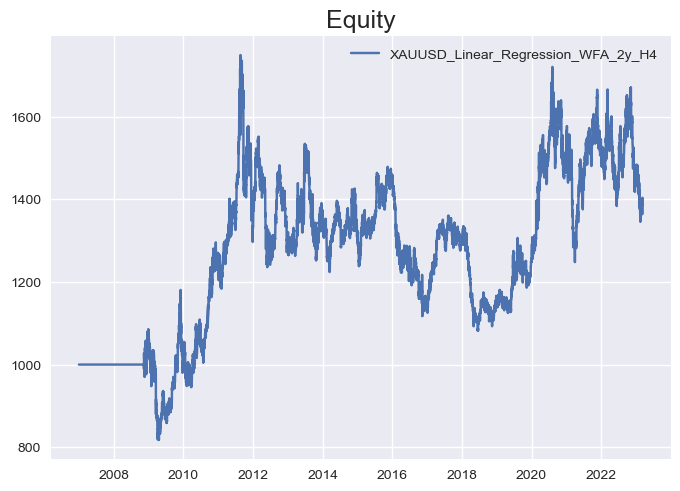

In [252]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [253]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [254]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 3 year

In [255]:
data = XAUUSD['H4']
window_size = 252 * 3 * 6
WFA = '3y'

In [256]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [257]:
test = ml.Run()

In [258]:
test

Start                     2007-01-01 04:00:00
End                       2023-03-10 12:00:00
Duration                   5912 days 08:00:00
Exposure Time [%]                   82.532533
Equity Final [$]                     1231.914
Equity Peak [$]                      1775.267
Return [%]                            23.1914
Buy & Hold Return [%]              193.059294
Return (Ann.) [%]                    1.047675
Volatility (Ann.) [%]               15.432936
Sharpe Ratio                         0.067886
Sortino Ratio                         0.09532
Calmar Ratio                         0.017855
Max. Drawdown [%]                  -58.676976
Avg. Drawdown [%]                   -1.839287
Max. Drawdown Duration     4217 days 12:00:00
Avg. Drawdown Duration       49 days 17:00:00
# Trades                                 5615
Win Rate [%]                        55.191451
Best Trade [%]                      32.728767
Worst Trade [%]                     -8.657804
Avg. Trade [%]                    

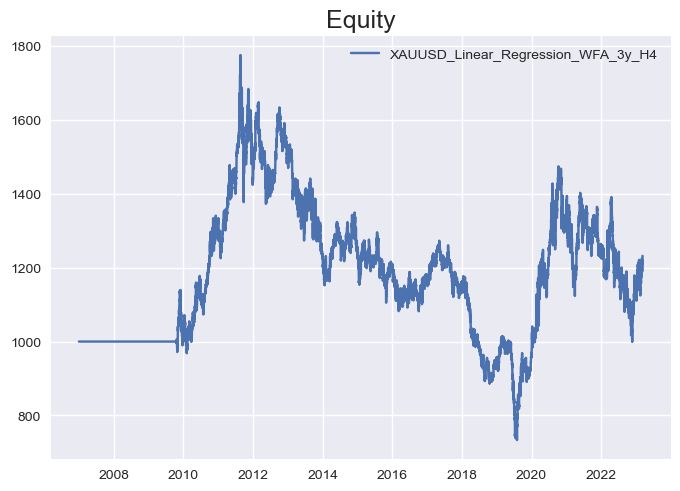

In [259]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [260]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [261]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 4 year

In [262]:
data = XAUUSD['H4']
window_size = 252 * 4 * 6
WFA = '4y'

In [263]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [264]:
test = ml.Run()

In [265]:
test

Start                     2007-01-01 04:00:00
End                       2023-03-10 12:00:00
Duration                   5912 days 08:00:00
Exposure Time [%]                   76.711327
Equity Final [$]                     1121.663
Equity Peak [$]                      1612.674
Return [%]                            12.1663
Buy & Hold Return [%]              193.059294
Return (Ann.) [%]                    0.575369
Volatility (Ann.) [%]               19.239407
Sharpe Ratio                         0.029906
Sortino Ratio                        0.042597
Calmar Ratio                         0.007879
Max. Drawdown [%]                  -73.025112
Avg. Drawdown [%]                   -2.415963
Max. Drawdown Duration     4217 days 16:00:00
Avg. Drawdown Duration       71 days 23:00:00
# Trades                                 5697
Win Rate [%]                        54.151308
Best Trade [%]                      22.213137
Worst Trade [%]                    -13.975704
Avg. Trade [%]                    

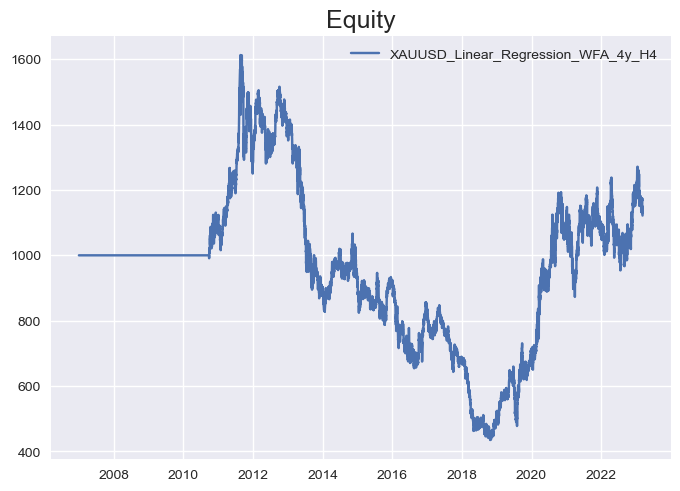

In [266]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [267]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [268]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 5 year

In [269]:
data = XAUUSD['H4']
window_size = 252 * 5 * 6
WFA = '5y'

In [270]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, 500)

In [271]:
test = ml.Run()

In [272]:
test

Start                     2007-01-01 04:00:00
End                       2023-03-10 12:00:00
Duration                   5912 days 08:00:00
Exposure Time [%]                    19.80442
Equity Final [$]                       10.263
Equity Peak [$]                       526.598
Return [%]                           -97.9474
Buy & Hold Return [%]              193.059294
Return (Ann.) [%]                  -17.649656
Volatility (Ann.) [%]               56.195909
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -98.051075
Avg. Drawdown [%]                  -25.107425
Max. Drawdown Duration     4203 days 12:00:00
Avg. Drawdown Duration     1051 days 04:00:00
# Trades                                  500
Win Rate [%]                             38.2
Best Trade [%]                       6.933755
Worst Trade [%]                    -19.962884
Avg. Trade [%]                    

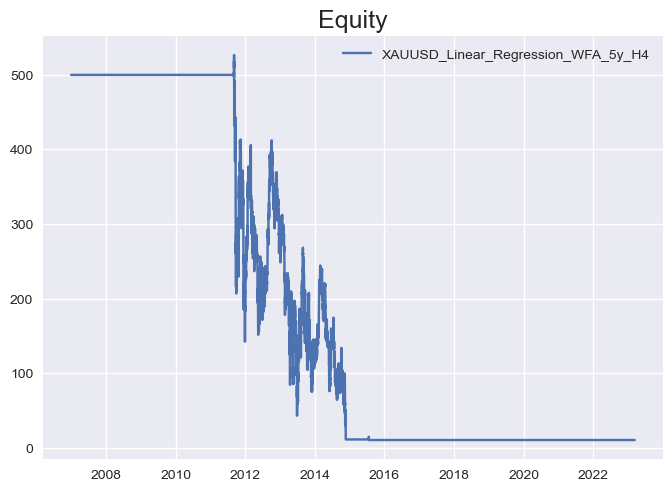

In [273]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [274]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [275]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 6 year

In [276]:
data = XAUUSD['H4']
window_size = 252 * 6 * 6
WFA = '6y'

In [277]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [278]:
test = ml.Run()

In [279]:
test

Start                     2007-01-01 04:00:00
End                       2023-03-10 12:00:00
Duration                   5912 days 08:00:00
Exposure Time [%]                   65.068915
Equity Final [$]                     1169.445
Equity Peak [$]                      1394.268
Return [%]                            16.9445
Buy & Hold Return [%]              193.059294
Return (Ann.) [%]                    0.785248
Volatility (Ann.) [%]               17.244954
Sharpe Ratio                         0.045535
Sortino Ratio                        0.065355
Calmar Ratio                         0.013987
Max. Drawdown [%]                  -56.142859
Avg. Drawdown [%]                   -3.264781
Max. Drawdown Duration     2853 days 00:00:00
Avg. Drawdown Duration       68 days 19:00:00
# Trades                                 4621
Win Rate [%]                        53.408353
Best Trade [%]                      10.567545
Worst Trade [%]                     -7.277274
Avg. Trade [%]                    

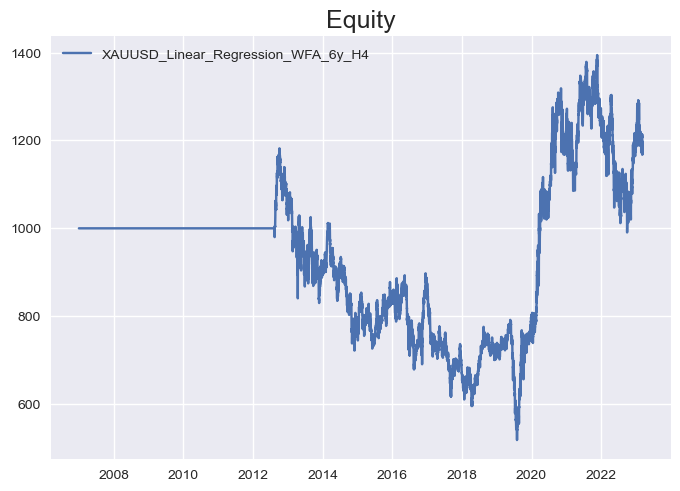

In [280]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [281]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [282]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 7 year

In [283]:
data = XAUUSD['H4']
window_size = 252 * 7 * 6
WFA = '7y'

In [284]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [285]:
test = ml.Run()

In [286]:
test

Start                     2007-01-01 04:00:00
End                       2023-03-10 12:00:00
Duration                   5912 days 08:00:00
Exposure Time [%]                   59.247709
Equity Final [$]                      730.272
Equity Peak [$]                      1094.704
Return [%]                           -26.9728
Buy & Hold Return [%]              193.059294
Return (Ann.) [%]                   -1.558484
Volatility (Ann.) [%]               27.017384
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -85.812877
Avg. Drawdown [%]                   -9.716836
Max. Drawdown Duration     3481 days 08:00:00
Avg. Drawdown Duration      351 days 04:00:00
# Trades                                 3829
Win Rate [%]                        53.120919
Best Trade [%]                       6.419461
Worst Trade [%]                     -5.546977
Avg. Trade [%]                    

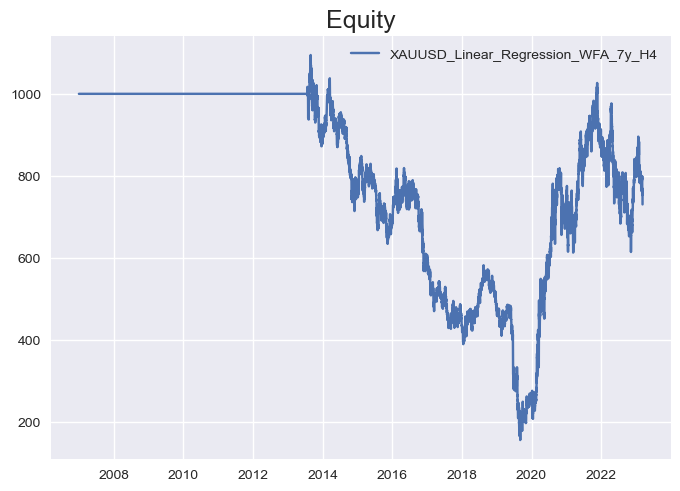

In [287]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [288]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [289]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 8 year

In [290]:
data = XAUUSD['H4']
window_size = 252 * 8 * 6
WFA = '8y'

In [291]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [292]:
test = ml.Run()

In [293]:
test

Start                     2007-01-01 04:00:00
End                       2023-03-10 12:00:00
Duration                   5912 days 08:00:00
Exposure Time [%]                   53.426503
Equity Final [$]                      246.753
Equity Peak [$]                      1028.258
Return [%]                           -75.3247
Buy & Hold Return [%]              193.059294
Return (Ann.) [%]                   -6.753788
Volatility (Ann.) [%]               29.416276
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -82.967699
Avg. Drawdown [%]                    -12.0794
Max. Drawdown Duration     3165 days 04:00:00
Avg. Drawdown Duration      452 days 14:00:00
# Trades                                 3399
Win Rate [%]                         54.19241
Best Trade [%]                       7.915663
Worst Trade [%]                    -11.451553
Avg. Trade [%]                    

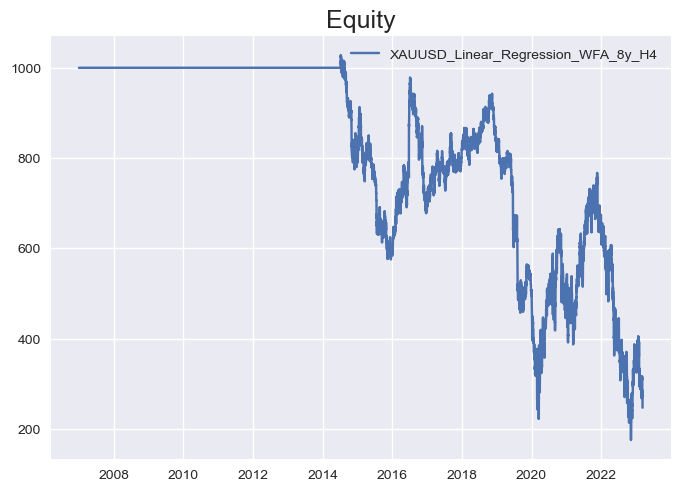

In [294]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [295]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [296]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

## TF H1

In [20]:
start_train = '2007'
end_train = '2023'
account_size = 1000
TF = 'H1'

### Window size 1 year

In [298]:
data = XAUUSD['H1']
window_size = 252 * 24
WFA = '1y'

In [299]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [300]:
test = ml.Run()

In [301]:
test

Start                     2007-01-01 01:00:00
End                       2023-03-10 16:00:00
Duration                   5912 days 15:00:00
Exposure Time [%]                   93.824526
Equity Final [$]                     2311.883
Equity Peak [$]                      2443.299
Return [%]                           131.1883
Buy & Hold Return [%]              191.774792
Return (Ann.) [%]                    4.276745
Volatility (Ann.) [%]               17.882963
Sharpe Ratio                         0.239152
Sortino Ratio                        0.357278
Calmar Ratio                         0.059795
Max. Drawdown [%]                  -71.522953
Avg. Drawdown [%]                   -0.940594
Max. Drawdown Duration     3587 days 08:00:00
Avg. Drawdown Duration       15 days 23:00:00
# Trades                                26604
Win Rate [%]                        52.774019
Best Trade [%]                       8.309427
Worst Trade [%]                     -9.086537
Avg. Trade [%]                    

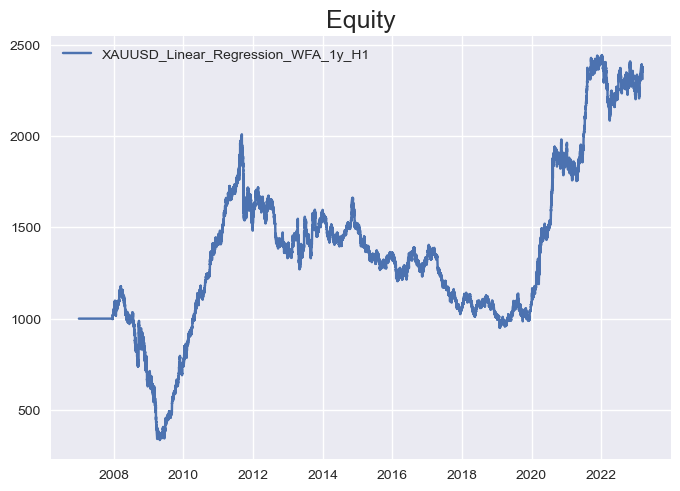

In [302]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [303]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [304]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 2 year

In [21]:
data = XAUUSD['H1']
window_size = 252 * 2 * 24
WFA = '2y'

In [22]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [23]:
test = ml.Run()

In [24]:
test

Start                     2007-01-01 01:00:00
End                       2023-03-10 16:00:00
Duration                   5912 days 15:00:00
Exposure Time [%]                   87.650074
Equity Final [$]                     2470.685
Equity Peak [$]                      2536.416
Return [%]                           147.0685
Buy & Hold Return [%]              191.774792
Return (Ann.) [%]                    4.623486
Volatility (Ann.) [%]               11.186314
Sharpe Ratio                         0.413316
Sortino Ratio                        0.611523
Calmar Ratio                         0.114711
Max. Drawdown [%]                  -40.305495
Avg. Drawdown [%]                   -0.905992
Max. Drawdown Duration     3270 days 21:00:00
Avg. Drawdown Duration       16 days 01:00:00
# Trades                                21190
Win Rate [%]                        50.689004
Best Trade [%]                      10.363046
Worst Trade [%]                     -5.919213
Avg. Trade [%]                    

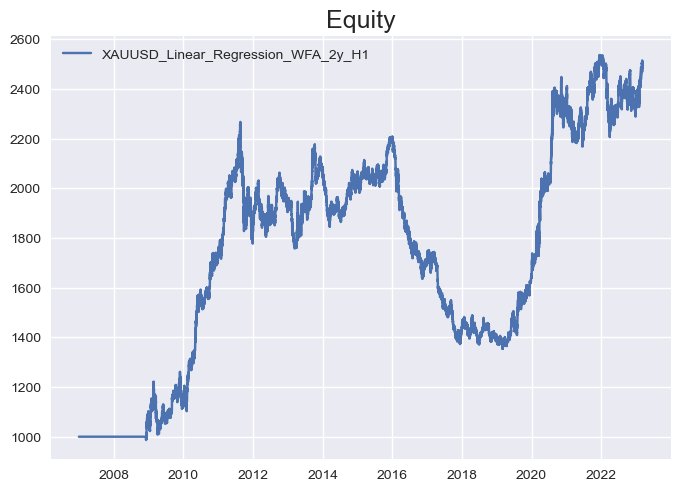

In [25]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [26]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [27]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 3 year

In [28]:
data = XAUUSD['H1']
window_size = 252 * 3 * 24
WFA = '3y'

In [29]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [30]:
test = ml.Run()

In [31]:
test

Start                     2007-01-01 01:00:00
End                       2023-03-10 16:00:00
Duration                   5912 days 15:00:00
Exposure Time [%]                   81.475621
Equity Final [$]                     1712.121
Equity Peak [$]                      1975.209
Return [%]                            71.2121
Buy & Hold Return [%]              191.774792
Return (Ann.) [%]                    2.723492
Volatility (Ann.) [%]               13.065721
Sharpe Ratio                         0.208446
Sortino Ratio                        0.299875
Calmar Ratio                          0.05626
Max. Drawdown [%]                  -48.408663
Avg. Drawdown [%]                   -0.922817
Max. Drawdown Duration     3366 days 22:00:00
Avg. Drawdown Duration       18 days 07:00:00
# Trades                                21336
Win Rate [%]                        47.211286
Best Trade [%]                        8.41223
Worst Trade [%]                    -14.873838
Avg. Trade [%]                    

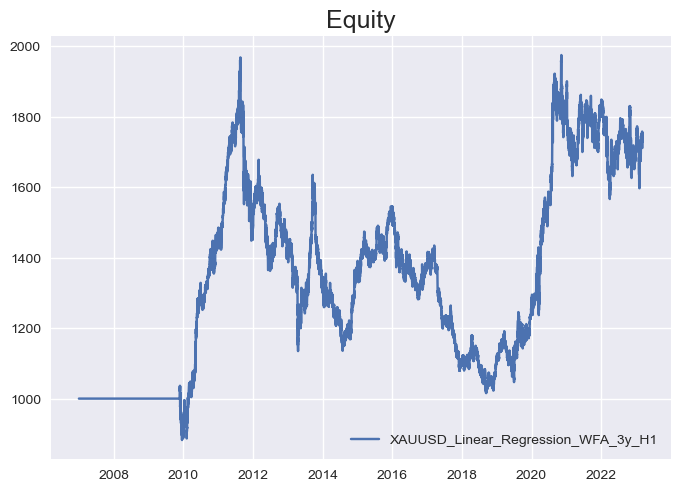

In [32]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [33]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [34]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 4 year

In [35]:
data = XAUUSD['H1']
window_size = 252 * 4 * 24
WFA = '4y'

In [36]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [37]:
test = ml.Run()

In [38]:
test

Start                     2007-01-01 01:00:00
End                       2023-03-10 16:00:00
Duration                   5912 days 15:00:00
Exposure Time [%]                   75.301168
Equity Final [$]                     1311.817
Equity Peak [$]                      1534.926
Return [%]                            31.1817
Buy & Hold Return [%]              191.774792
Return (Ann.) [%]                    1.365498
Volatility (Ann.) [%]               26.516039
Sharpe Ratio                         0.051497
Sortino Ratio                        0.074711
Calmar Ratio                         0.017409
Max. Drawdown [%]                  -78.436029
Avg. Drawdown [%]                   -1.462506
Max. Drawdown Duration     4203 days 11:00:00
Avg. Drawdown Duration       31 days 22:00:00
# Trades                                19356
Win Rate [%]                        46.290556
Best Trade [%]                       10.18398
Worst Trade [%]                     -7.867601
Avg. Trade [%]                    

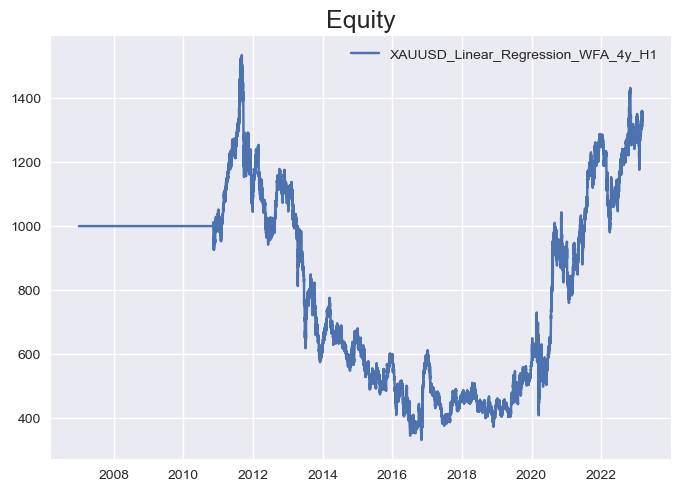

In [39]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [40]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [41]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 5 year

In [42]:
data = XAUUSD['H1']
window_size = 252 * 5 * 24
WFA = '5y'

In [43]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [44]:
test = ml.Run()

In [45]:
test

Start                     2007-01-01 01:00:00
End                       2023-03-10 16:00:00
Duration                   5912 days 15:00:00
Exposure Time [%]                     38.4668
Equity Final [$]                       11.531
Equity Peak [$]                      1036.036
Return [%]                           -98.8469
Buy & Hold Return [%]              191.774792
Return (Ann.) [%]                  -19.988761
Volatility (Ann.) [%]               52.667612
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -98.887973
Avg. Drawdown [%]                  -16.117168
Max. Drawdown Duration     4132 days 20:00:00
Avg. Drawdown Duration      592 days 15:00:00
# Trades                                 8570
Win Rate [%]                        42.893816
Best Trade [%]                       3.102227
Worst Trade [%]                     -6.435078
Avg. Trade [%]                    

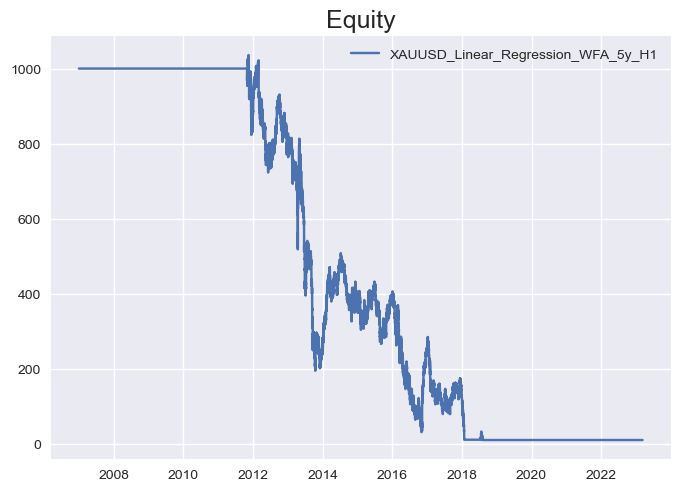

In [46]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [47]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [48]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 6 year

In [49]:
data = XAUUSD['H1']
window_size = 252 * 6 * 24
WFA = '6y'

In [50]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [51]:
test = ml.Run()

In [52]:
test

Start                     2007-01-01 01:00:00
End                       2023-03-10 16:00:00
Duration                   5912 days 15:00:00
Exposure Time [%]                   31.981991
Equity Final [$]                       11.284
Equity Peak [$]                       1037.29
Return [%]                           -98.8716
Buy & Hold Return [%]              191.774792
Return (Ann.) [%]                  -20.075288
Volatility (Ann.) [%]               38.862526
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -98.926337
Avg. Drawdown [%]                   -7.430235
Max. Drawdown Duration     3759 days 01:00:00
Avg. Drawdown Duration      252 days 11:00:00
# Trades                                 7587
Win Rate [%]                        41.729274
Best Trade [%]                       3.611285
Worst Trade [%]                     -6.435078
Avg. Trade [%]                    

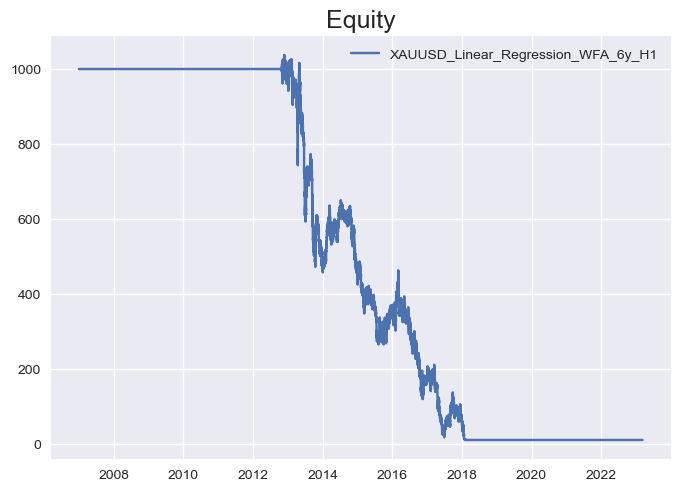

In [53]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [54]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [55]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 7 year

In [56]:
data = XAUUSD['H1']
window_size = 252 * 7 * 24
WFA = '7y'

In [57]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [58]:
test = ml.Run()

In [59]:
test

Start                     2007-01-01 01:00:00
End                       2023-03-10 16:00:00
Duration                   5912 days 15:00:00
Exposure Time [%]                   39.296798
Equity Final [$]                       13.637
Equity Peak [$]                      1119.753
Return [%]                           -98.6363
Buy & Hold Return [%]              191.774792
Return (Ann.) [%]                  -19.315256
Volatility (Ann.) [%]               37.555908
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -98.782142
Avg. Drawdown [%]                    -3.53519
Max. Drawdown Duration     3283 days 04:00:00
Avg. Drawdown Duration       95 days 00:00:00
# Trades                                10938
Win Rate [%]                        41.570671
Best Trade [%]                       4.579695
Worst Trade [%]                     -5.124316
Avg. Trade [%]                    

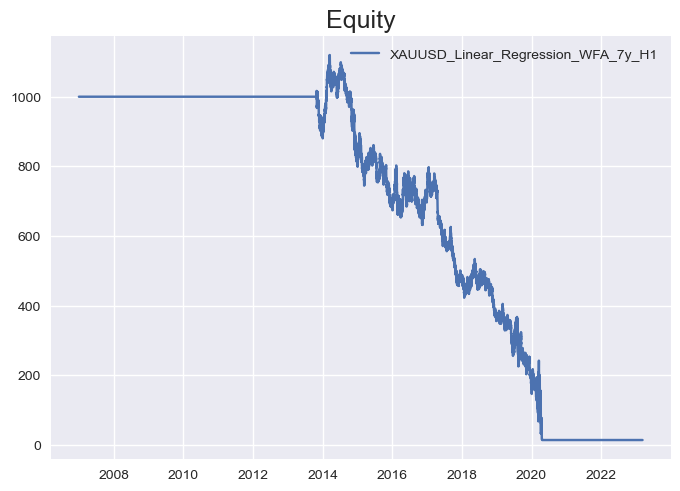

In [60]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [61]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [62]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 8 year

In [63]:
data = XAUUSD['H1']
window_size = 252 * 8 * 24
WFA = '8y'

In [64]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [65]:
test = ml.Run()

In [66]:
test

Start                     2007-01-01 01:00:00
End                       2023-03-10 16:00:00
Duration                   5912 days 15:00:00
Exposure Time [%]                   34.248407
Equity Final [$]                        14.83
Equity Peak [$]                      1004.097
Return [%]                            -98.517
Buy & Hold Return [%]              191.774792
Return (Ann.) [%]                  -18.976415
Volatility (Ann.) [%]               25.468231
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -98.523051
Avg. Drawdown [%]                  -98.523051
Max. Drawdown Duration     3055 days 02:00:00
Avg. Drawdown Duration     3055 days 02:00:00
# Trades                                 8671
Win Rate [%]                        39.303425
Best Trade [%]                       4.434381
Worst Trade [%]                     -7.385885
Avg. Trade [%]                    

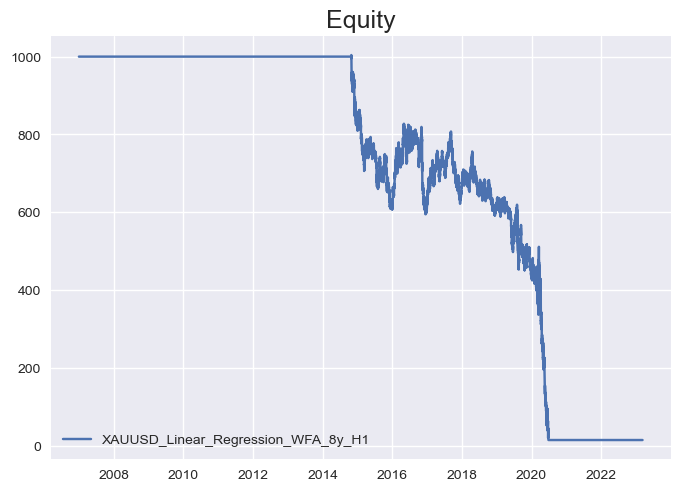

In [67]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [68]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [69]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

## TF H30

In [14]:
start_train = '2007'
end_train = '2023'
account_size = 1000
TF = 'M30'

### Window size 1 year

In [71]:
data = XAUUSD['M30']
window_size = 252 * 48
WFA = '1y'

In [72]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [73]:
test = ml.Run()

In [74]:
test

Start                     2007-01-01 00:30:00
End                       2023-03-10 17:00:00
Duration                   5912 days 16:30:00
Exposure Time [%]                    8.765334
Equity Final [$]                        6.396
Equity Peak [$]                      1058.669
Return [%]                           -99.3604
Buy & Hold Return [%]              193.026695
Return (Ann.) [%]                  -22.310794
Volatility (Ann.) [%]               24.339095
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -99.395845
Avg. Drawdown [%]                   -3.728418
Max. Drawdown Duration     5478 days 08:30:00
Avg. Drawdown Duration      163 days 11:12:00
# Trades                                 5333
Win Rate [%]                        43.633977
Best Trade [%]                       7.118609
Worst Trade [%]                    -11.566214
Avg. Trade [%]                    

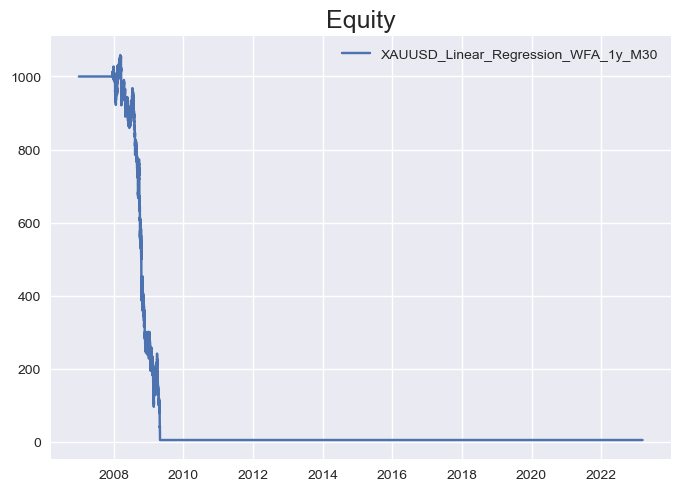

In [75]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [76]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [77]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 2 year

In [78]:
data = XAUUSD['M30']
window_size = 252 * 2 * 48
WFA = '2y'

In [79]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [80]:
test = ml.Run()

In [81]:
test

Start                     2007-01-01 00:30:00
End                       2023-03-10 17:00:00
Duration                   5912 days 16:30:00
Exposure Time [%]                   87.608267
Equity Final [$]                     3478.727
Equity Peak [$]                       3514.43
Return [%]                           247.8727
Buy & Hold Return [%]              193.026695
Return (Ann.) [%]                    6.427758
Volatility (Ann.) [%]               12.947333
Sharpe Ratio                         0.496454
Sortino Ratio                        0.736066
Calmar Ratio                         0.187393
Max. Drawdown [%]                  -34.300965
Avg. Drawdown [%]                   -0.606933
Max. Drawdown Duration     3045 days 18:00:00
Avg. Drawdown Duration        7 days 09:19:00
# Trades                                43917
Win Rate [%]                        60.527814
Best Trade [%]                      21.826475
Worst Trade [%]                     -7.768204
Avg. Trade [%]                    

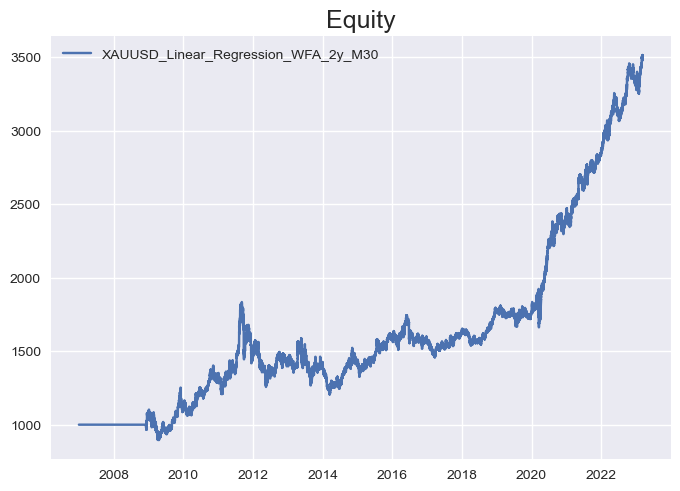

In [82]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [83]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [84]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 3 year

In [85]:
data = XAUUSD['M30']
window_size = 252 * 3 * 48
WFA = '3y'

In [86]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [87]:
test = ml.Run()

In [88]:
test

Start                     2007-01-01 00:30:00
End                       2023-03-10 17:00:00
Duration                   5912 days 16:30:00
Exposure Time [%]                   81.412657
Equity Final [$]                     3211.095
Equity Peak [$]                      3246.798
Return [%]                           221.1095
Buy & Hold Return [%]              193.026695
Return (Ann.) [%]                    6.002861
Volatility (Ann.) [%]                15.82402
Sharpe Ratio                         0.379351
Sortino Ratio                        0.566725
Calmar Ratio                         0.098579
Max. Drawdown [%]                  -60.894097
Avg. Drawdown [%]                   -0.667447
Max. Drawdown Duration     3211 days 08:00:00
Avg. Drawdown Duration        7 days 16:06:00
# Trades                                42665
Win Rate [%]                        60.801594
Best Trade [%]                       9.010744
Worst Trade [%]                      -8.22294
Avg. Trade [%]                    

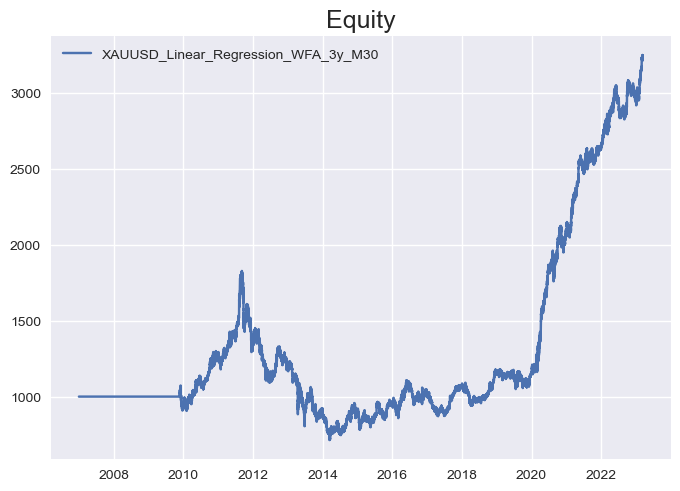

In [89]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [90]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [91]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 4 year

In [92]:
data = XAUUSD['M30']
window_size = 252 * 4 * 48
WFA = '4y'

In [93]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [94]:
test = ml.Run()

In [95]:
test

Start                     2007-01-01 00:30:00
End                       2023-03-10 17:00:00
Duration                   5912 days 16:30:00
Exposure Time [%]                   75.217046
Equity Final [$]                     3294.154
Equity Peak [$]                      3329.857
Return [%]                           229.4154
Buy & Hold Return [%]              193.026695
Return (Ann.) [%]                    6.138219
Volatility (Ann.) [%]               20.435336
Sharpe Ratio                         0.300373
Sortino Ratio                        0.442927
Calmar Ratio                         0.095976
Max. Drawdown [%]                   -63.95587
Avg. Drawdown [%]                   -0.630456
Max. Drawdown Duration     3143 days 10:00:00
Avg. Drawdown Duration        7 days 06:23:00
# Trades                                40241
Win Rate [%]                        62.200244
Best Trade [%]                       4.698195
Worst Trade [%]                     -13.61835
Avg. Trade [%]                    

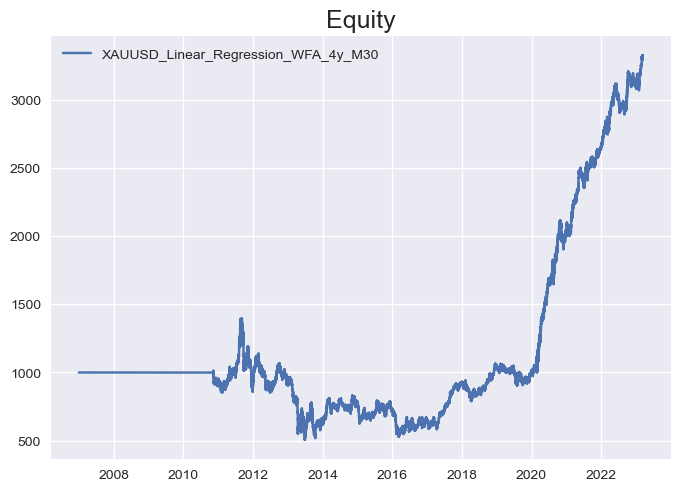

In [96]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [97]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [98]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 5 year

In [99]:
data = XAUUSD['M30']
window_size = 252 * 5 * 48
WFA = '5y'

In [100]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [101]:
test = ml.Run()

In [102]:
test

Start                     2007-01-01 00:30:00
End                       2023-03-10 17:00:00
Duration                   5912 days 16:30:00
Exposure Time [%]                   69.021436
Equity Final [$]                     3157.181
Equity Peak [$]                      3192.884
Return [%]                           215.7181
Buy & Hold Return [%]              193.026695
Return (Ann.) [%]                    5.913208
Volatility (Ann.) [%]               24.294781
Sharpe Ratio                         0.243394
Sortino Ratio                         0.36231
Calmar Ratio                         0.087352
Max. Drawdown [%]                   -67.69405
Avg. Drawdown [%]                   -0.654313
Max. Drawdown Duration     2599 days 23:30:00
Avg. Drawdown Duration        6 days 13:47:00
# Trades                                38363
Win Rate [%]                        61.872116
Best Trade [%]                       8.803892
Worst Trade [%]                    -19.580415
Avg. Trade [%]                    

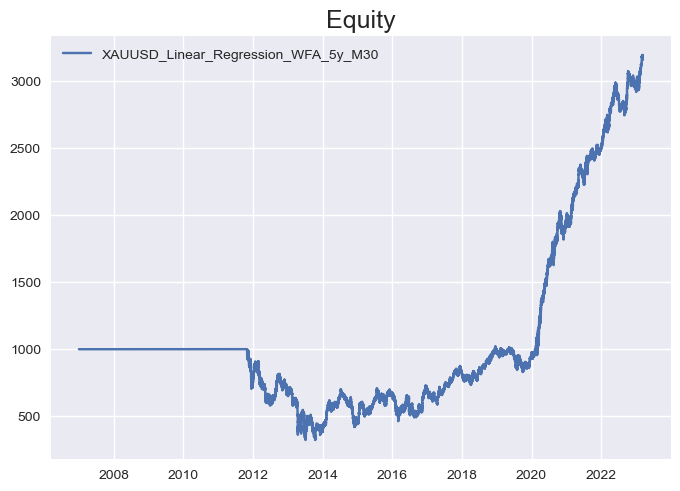

In [103]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [104]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [105]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 6 year

In [11]:
data = XAUUSD['M30']
window_size = 252 * 6 * 48
WFA = '6y'

In [15]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [16]:
test = ml.Run()

In [17]:
test

Start                     2007-01-01 00:30:00
End                       2023-03-10 17:00:00
Duration                   5912 days 16:30:00
Exposure Time [%]                   62.825825
Equity Final [$]                     2801.105
Equity Peak [$]                      2836.808
Return [%]                           180.1105
Buy & Hold Return [%]              193.026695
Return (Ann.) [%]                    5.281767
Volatility (Ann.) [%]               28.967724
Sharpe Ratio                         0.182333
Sortino Ratio                        0.279918
Calmar Ratio                         0.067541
Max. Drawdown [%]                  -78.201376
Avg. Drawdown [%]                   -0.702403
Max. Drawdown Duration     2733 days 14:00:00
Avg. Drawdown Duration        7 days 05:41:00
# Trades                                37721
Win Rate [%]                        61.938973
Best Trade [%]                       4.158447
Worst Trade [%]                    -10.332263
Avg. Trade [%]                    

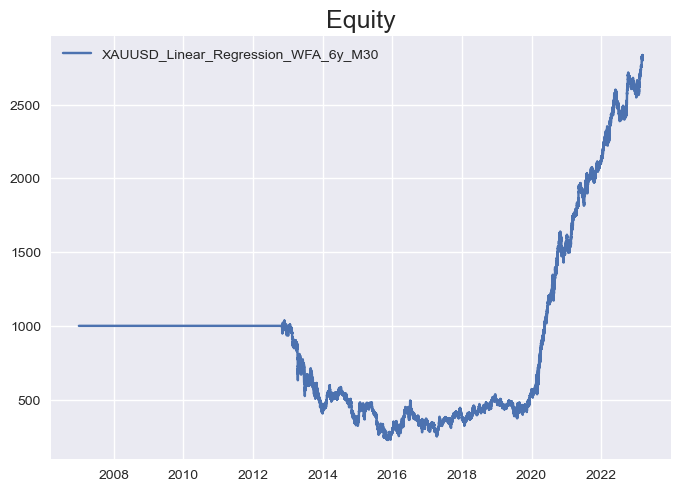

In [18]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [19]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [20]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 7 year

In [21]:
data = XAUUSD['M30']
window_size = 252 * 7 * 48 
WFA = '7y'

In [22]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [23]:
test = ml.Run()

In [24]:
test

Start                     2007-01-01 00:30:00
End                       2023-03-10 17:00:00
Duration                   5912 days 16:30:00
Exposure Time [%]                   56.630215
Equity Final [$]                     3063.034
Equity Peak [$]                      3098.737
Return [%]                           206.3034
Buy & Hold Return [%]              193.026695
Return (Ann.) [%]                    5.753106
Volatility (Ann.) [%]               13.460322
Sharpe Ratio                         0.427412
Sortino Ratio                        0.674133
Calmar Ratio                           0.1232
Max. Drawdown [%]                  -46.697338
Avg. Drawdown [%]                   -0.555791
Max. Drawdown Duration     2240 days 11:00:00
Avg. Drawdown Duration        5 days 10:27:00
# Trades                                37379
Win Rate [%]                        62.302362
Best Trade [%]                       5.015049
Worst Trade [%]                      -7.29916
Avg. Trade [%]                    

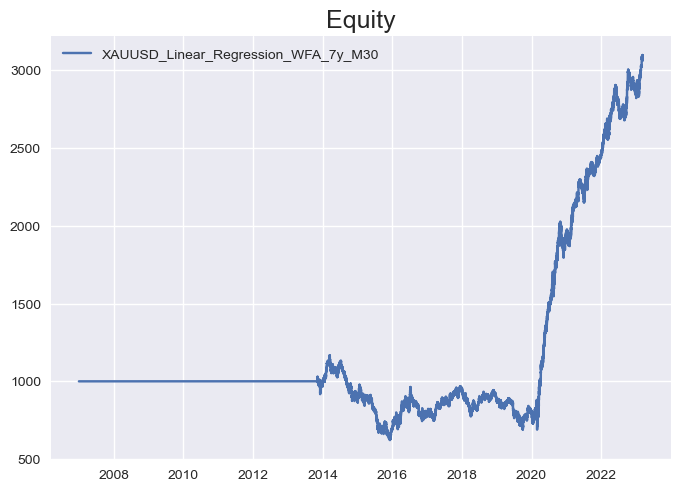

In [25]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [26]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [27]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 8 year

In [28]:
data = XAUUSD['M30']
window_size = 252 * 8 * 48
WFA = '8y'

In [29]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [30]:
test = ml.Run()

In [31]:
test

Start                     2007-01-01 00:30:00
End                       2023-03-10 17:00:00
Duration                   5912 days 16:30:00
Exposure Time [%]                   50.434604
Equity Final [$]                     3438.638
Equity Peak [$]                      3474.341
Return [%]                           243.8638
Buy & Hold Return [%]              193.026695
Return (Ann.) [%]                    6.366133
Volatility (Ann.) [%]               10.795613
Sharpe Ratio                         0.589696
Sortino Ratio                        0.941436
Calmar Ratio                         0.211585
Max. Drawdown [%]                  -30.087807
Avg. Drawdown [%]                   -0.544061
Max. Drawdown Duration      959 days 13:30:00
Avg. Drawdown Duration        4 days 04:00:00
# Trades                                36383
Win Rate [%]                        62.751835
Best Trade [%]                        3.18745
Worst Trade [%]                     -4.818441
Avg. Trade [%]                    

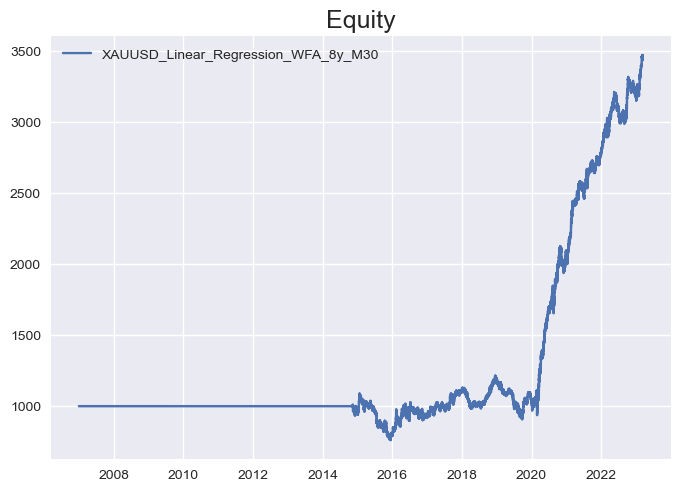

In [32]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [33]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [34]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')